# Define Functions

Get Records

In [ ]:
import requests
from bs4 import BeautifulSoup as soup

In [ ]:
headers = {
  "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36"
}

In [ ]:
def get_news_url(search_word, headers=headers):
  url = f'https://www.expo2025.or.jp/?s={search_word}'
  search_page_response = requests.get(url, headers=headers)
  search_page_soup_page = soup(search_page_response.text, 'html')

  no_search_results = int(search_page_soup_page.find("strong").get_text())
  no_page = (no_search_results//10) + (1 if no_search_results%10>0 else 0) # 10 results per page

  news_urls = []
  for i in range(no_page):
    current_page_no = str(i+1)
    url = f'https://www.expo2025.or.jp/page/{current_page_no}?s={search_word}'
    search_page_response = requests.get(url, headers=headers)
    search_page_soup_page = soup(search_page_response.text, 'html')
    news_urls += [a['href'] for a in search_page_soup_page.find("div",{'class':'search_list'}).findAll("a")]

  return news_urls

In [ ]:
def get_entries_data(search_word, headers=headers):
  new_urls = get_news_url(search_word)
  date = []
  entries = []
  for news_url in news_urls:
    news_response = requests.get(news_url, headers=headers)
    news_soup_page = soup(news_response.text, 'html')
    entry_records = news_soup_page.find('tbody').findAll('tr')[1:-1]
    date += [ i.findAll('td')[0].text for i in entry_records ]
    entries += [ int(i.findAll('td')[1].text.replace(',','')) for i in entry_records ]
  return date, entries

Pandas DataFrame

In [ ]:
import pandas as pd
from datetime import datetime

In [ ]:
def get_entries_table(search_word):
  date, entries = get_entries_data(search_word)

  data = {
      'Date & Weekdays': date,
      'Entries': entries
  }

  df = pd.DataFrame(data)
  date_format = '%m月%d日'
  df['Date'] = df['Date & Weekdays'].apply(lambda x:datetime.strptime(x.split("（")[0],date_format).date().replace(year=2025))
  df['Weekday'] = df['Date'].apply(lambda x:x.weekday()+1)
  df['Weekday (Japanese)'] = df['Date & Weekdays'].apply(lambda x:x.split('（')[1][0])

  return df

Graph

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def get_date_entries_barchart(df):
  plt.figure(figsize=(18, 10))

  # Filter for Mondays
  mondays = df[df['Weekday'] == 1]['Date']

  sns.barplot(x='Date', y='Entries', data=df, hue = 'Weekday') # to use custom colors: palette=weekday_colors
  plt.xlabel('Date')
  plt.ylabel('Entries')

  # Set X-axis ticks to only Mondays
  plt.gca().set_xticks(mondays.apply(lambda x:str(x)))
  plt.gca().set_xticklabels(mondays, rotation=45, ha='right')

  # invert the axis
  plt.gca().invert_xaxis()

# Run Functions

In [ ]:
df = get_entries_table('来場者数と入場チケット販売数について')

/tmp/ipython-input-1802587977.py:15: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  news_urls += [a['href'] for a in search_page_soup_page.find("div",{'class':'search_list'}).findAll("a")]
/tmp/ipython-input-1875760270.py:8: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  entry_records = news_soup_page.find('tbody').findAll('tr')[1:-1]
/tmp/ipython-input-1875760270.py:9: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  date += [ i.findAll('td')[0].text for i in entry_records ]
/tmp/ipython-input-1875760270.py:10: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  entries += [ int(i.findAll('td')[1].text.replace(',','')) for i in entry_records ]


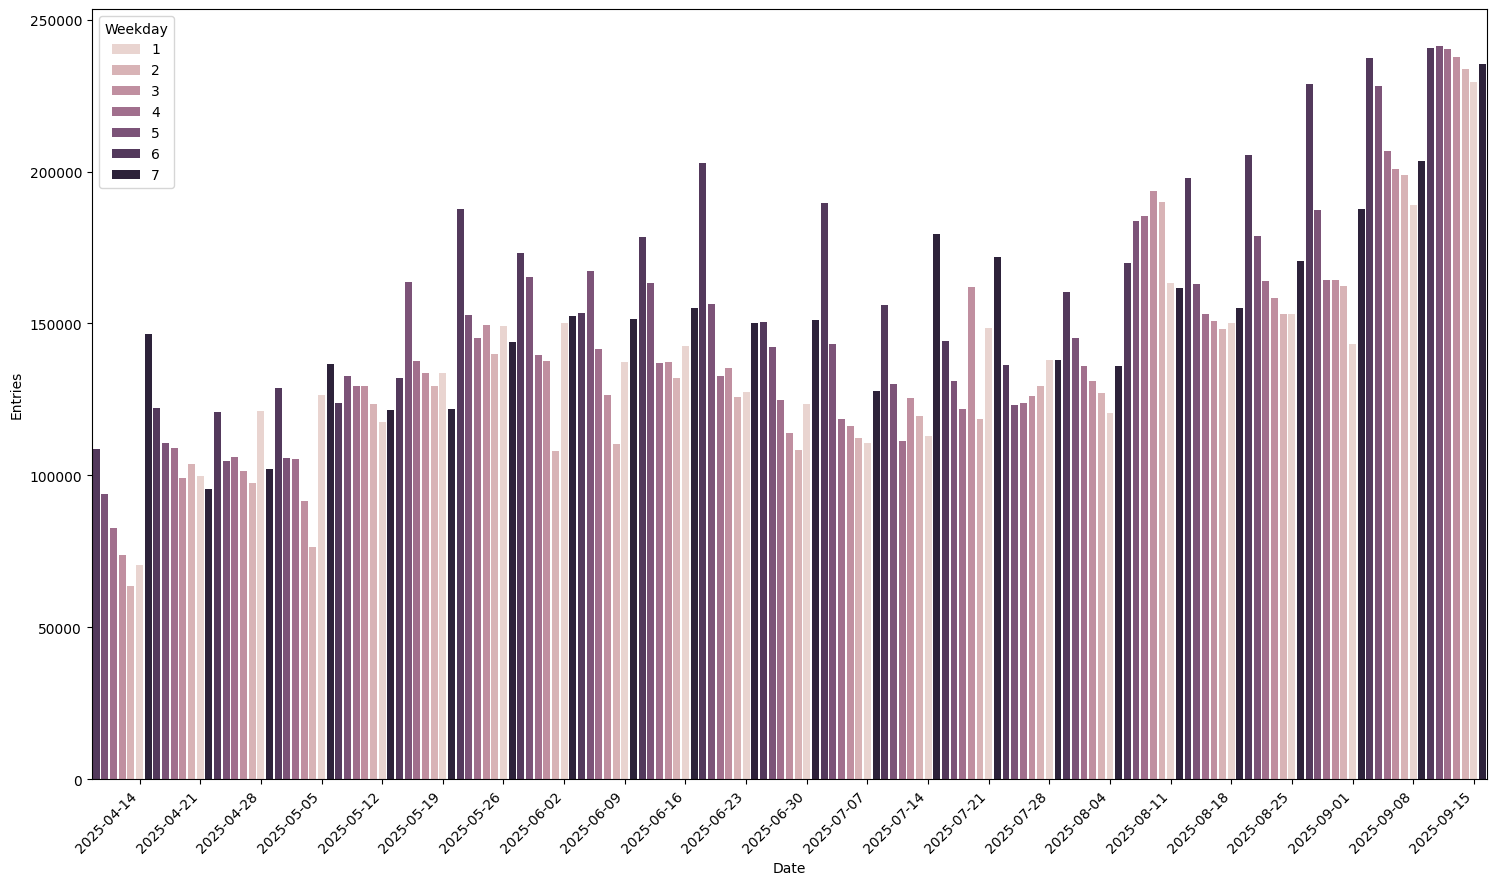

In [ ]:
#get_date_entries_barchart(get_entries_table('来場者数と入場チケット販売数について'))
get_date_entries_barchart(df)